In [1]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Dataset/20_newsgroups.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import os
import pandas as pd

def load_20newsgroups_data(data_dir):
    data = []
    labels = []
    for newsgroup in os.listdir(data_dir):
        newsgroup_dir = os.path.join(data_dir, newsgroup)
        if os.path.isdir(newsgroup_dir):
            for filename in os.listdir(newsgroup_dir):
                filepath = os.path.join(newsgroup_dir, filename)
                with open(filepath, 'r', errors='ignore') as file:
                    content = file.read()
                    data.append(content)
                    labels.append(newsgroup)
    return pd.DataFrame({'text': data, 'label': labels})


data_dir = '/content/20_newsgroups'
df = load_20newsgroups_data(data_dir)
print(df.head())

                                                text                  label
0  Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....  comp.sys.mac.hardware
1  Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....  comp.sys.mac.hardware
2  Newsgroups: comp.sys.mac.hardware\nPath: canta...  comp.sys.mac.hardware
3  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  comp.sys.mac.hardware
4  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  comp.sys.mac.hardware


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19997 non-null  object
 1   label   19997 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(text):
    text = re.sub(r'(From|Subject|Date|Newsgroups|Message-ID|Organization|Lines|Path|Xref|NNTP-Posting-Host|X-Newsreader|X-Mailer|Xref|Distribution|Expires|Followup-To|Reply-To|Approved|Sender|In-Reply-To|References|Article-I.D.):.*\n', '', text)
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)       # Remove newlines
    text = re.sub(r'>', '', text)        # Remove quote symbols

    stop_words = set(stopwords.words('english'))
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

data_dir = '/content/20_newsgroups'
df = load_20newsgroups_data(data_dir)
df['processed_text'] = df['text'].apply(preprocess_text)

In [7]:
df.head()

,text,label,processed_text
0,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,comp.sys.mac.hardware,article jasaprtiggerisiedu jasisiedu jeff sull...
1,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,comp.sys.mac.hardware,xuseragent nuntius vdxxxxxxhello netpeoplewe l...
2,Newsgroups: comp.sys.mac.hardware\nPath: canta...,comp.sys.mac.hardware,nntppostinghost admindo accelaratores make lot...
3,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,comp.sys.mac.hardware,article summeralrintintincoloradoedu summeralr...
4,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,comp.sys.mac.hardware,dblaserwriter iintx upgrade kit isdbits small ...


In [8]:
df.drop(['text'], axis=1, inplace=True)

In [9]:
df.to_csv('20_newsgroups.csv', index=False)

In [10]:
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=3, max_df=0.85)
X = vectorizer.fit_transform(df['processed_text'])

In [11]:
X.toarray().shape

(19997, 25000)

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X.toarray())

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0, n_init=20, init='k-means++', max_iter=300)
kmeans.fit(X_reduced)
df['cluster'] = kmeans.labels_

In [14]:
df.head()

,label,processed_text,cluster
0,comp.sys.mac.hardware,article jasaprtiggerisiedu jasisiedu jeff sull...,3
1,comp.sys.mac.hardware,xuseragent nuntius vdxxxxxxhello netpeoplewe l...,18
2,comp.sys.mac.hardware,nntppostinghost admindo accelaratores make lot...,18
3,comp.sys.mac.hardware,article summeralrintintincoloradoedu summeralr...,7
4,comp.sys.mac.hardware,dblaserwriter iintx upgrade kit isdbits small ...,18


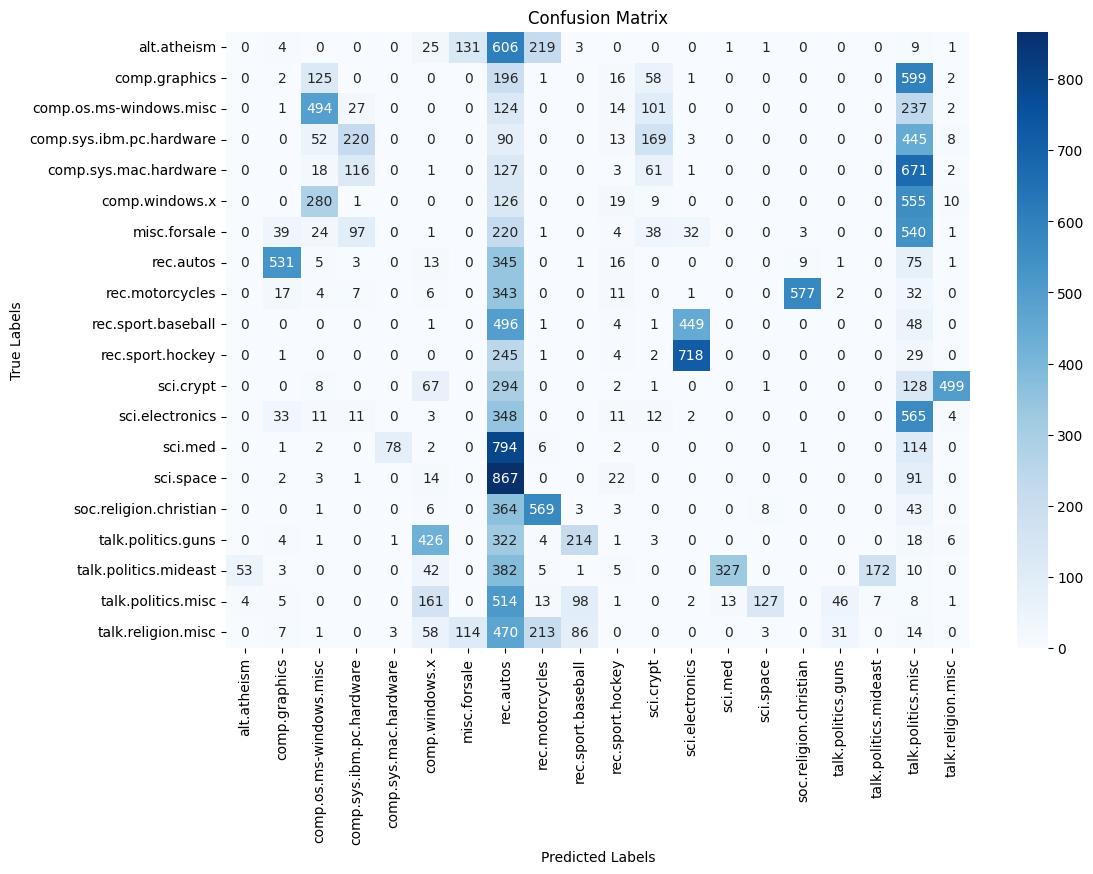

In [15]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['label'])

conf_matrix = confusion_matrix(true_labels_encoded, kmeans.labels_)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(df['label'], kmeans.labels_)
completeness = completeness_score(df['label'], kmeans.labels_)
v_measure = v_measure_score(df['label'], kmeans.labels_)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-measure: {v_measure}')

Homogeneity: 0.3460067457404158
Completeness: 0.4777540374020615
V-measure: 0.4013449611311271
